In [8]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import mpl_toolkits as mpl
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [9]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

In [10]:
def unnormalised_ground_truth(x1,x2):
    """return the 'ground truth' output for a specific input location x"""
    y = (10 * np.sin(2 * x1 + x2) +
         5 * np.cos(x1 * x2) +
         np.exp(-0.1 * (x1**2 + x2**2)) +
         3 * x1**2 * np.log(1 + x2**2))
    return y

def normalised_ground_truth(x1,x2):
    ys = unnormalised_ground_truth(x1,x2)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s


def generate_dataset(size=500, noise=0.15, split=0.3):
    x1_grid = np.linspace(-3, 3, 1000)
    x2_grid = np.linspace(-3, 3, 1000)
    x1, x2 = np.meshgrid(x1_grid, x2_grid) # make grid
    x_grid = np.column_stack((x1.flatten(), x2.flatten())) # flatten to pass into function
    ys = normalised_ground_truth(x_grid[:, 0], x_grid[:, 1])
    sample_indices = np.random.choice(len(x_grid), size=size, replace=False) # take random samples

    x_samples = x_grid[sample_indices,:]
    y_samples = ys[sample_indices] + np.random.normal(0, noise, size)

    return train_test_split(x_samples, y_samples, test_size=split, random_state=13)
 


In [11]:
x_tr, x_te, y_tr, y_te = generate_dataset(500, 0.15, 0.3)
x_tr = torch.FloatTensor(x_tr)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

In [12]:
from GaussianBBB import MeanFieldBNN

In [13]:
bnn_model = MeanFieldBNN(2, [6, 6, 4], 1, noise_std=0.15, prior_var = 0.3)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-2
)

MeanFieldBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): ELU(alpha=1.0)
    (2): MeanFieldLayer()
    (3): ELU(alpha=1.0)
    (4): MeanFieldLayer()
    (5): ELU(alpha=1.0)
    (6): MeanFieldLayer()
  )
)


In [14]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

for epoch in tqdm(range(4000)):  # epochs
    opt.zero_grad()

    l, ll, kl = bnn_model.loss(x_tr, y_tr,num_samples = 1000)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(bnn_model(x_tr), y_tr.unsqueeze(0)).item())

    te_loss_evo.append(bnn_model.loss(x_te, y_te)[0].item())
    te_mse_loss_evo.append(aux_loss(bnn_model(x_te), y_te.unsqueeze(0)).item())

    l.backward()
    opt.step()

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

  0%|          | 2/4000 [00:00<04:53, 13.61it/s]

torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])


  0%|          | 6/4000 [00:00<04:14, 15.67it/s]

torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])


  0%|          | 8/4000 [00:00<04:18, 15.46it/s]

torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])


  0%|          | 12/4000 [00:00<04:34, 14.54it/s]

torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])


  0%|          | 14/4000 [00:00<04:33, 14.56it/s]

torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])


  0%|          | 18/4000 [00:01<04:45, 13.93it/s]

torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])


  0%|          | 20/4000 [00:01<04:37, 14.36it/s]

torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])


  1%|          | 24/4000 [00:01<04:34, 14.49it/s]

torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])


  1%|          | 28/4000 [00:01<04:38, 14.27it/s]

torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])


  1%|          | 30/4000 [00:02<04:35, 14.40it/s]

torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])


  1%|          | 34/4000 [00:02<04:53, 13.51it/s]

torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])


  1%|          | 36/4000 [00:02<04:50, 13.65it/s]

torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])


  1%|          | 38/4000 [00:02<05:01, 13.13it/s]

torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])


  1%|          | 42/4000 [00:03<05:15, 12.55it/s]

torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])


  1%|          | 46/4000 [00:03<04:48, 13.72it/s]

torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])


  1%|          | 48/4000 [00:03<04:32, 14.52it/s]

torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])


  1%|▏         | 52/4000 [00:03<04:52, 13.48it/s]

torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])


  1%|▏         | 54/4000 [00:04<06:04, 10.82it/s]

torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])


  1%|▏         | 56/4000 [00:04<06:49,  9.63it/s]

torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])


  1%|▏         | 58/4000 [00:04<07:26,  8.83it/s]

torch.Size([1000, 350, 2])
torch.Size([1, 350, 2])
torch.Size([1, 150, 2])
torch.Size([1, 150, 2])
torch.Size([1000, 350, 2])


  1%|▏         | 58/4000 [00:04<05:12, 12.62it/s]


KeyboardInterrupt: 

In [61]:
bnn_model = MeanFieldBNN(2, [6, 6, 4], 1, noise_std=0.15, prior_var = 0.3)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-2
)

MeanFieldBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): ELU(alpha=1.0)
    (2): MeanFieldLayer()
    (3): ELU(alpha=1.0)
    (4): MeanFieldLayer()
    (5): ELU(alpha=1.0)
    (6): MeanFieldLayer()
  )
)


In [ ]:
y_tr.shape

torch.Size([350])

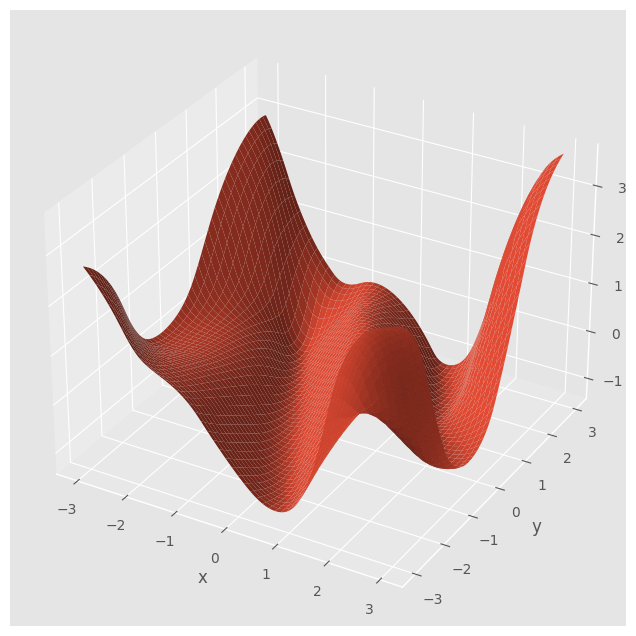

In [ ]:
# Plotting mean prediction
x1_grid = np.arange(-3,3,0.01)
x2_grid = np.arange(-3,3,0.01)
x1, x2 = np.meshgrid(x1_grid, x2_grid) # make grid
x_grid = torch.FloatTensor(np.column_stack((x1.flatten(), x2.flatten()))) 
ys = bnn_model(x_grid, 100).mean(0).detach().numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Z = ys.reshape(x1.shape)
ax.plot_surface(x1,x2,Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()

In [ ]:
alpha_values = np.arange(0.05, 1.0, 0.05)
num_splits = 4  # Number of train/test splits
num_samples = 1000  # BNN posterior samples
epochs = 100  # Training epochs
mcp_results = {alpha: [] for alpha in alpha_values}  # Store MCP for each alpha

mcp_values = []

for _ in tqdm(range(num_splits)):
    # Generate new dataset
    x_tr, x_te, y_tr, y_te = generate_dataset(size=600, noise=0.15, split=1/6) # 100 to train
    y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
    x_tr = torch.FloatTensor(x_tr)
    # Initialize a new BNN
    bnn_model = MeanFieldBNN(2, [6, 6 , 4], 1, noise_std=0.15, prior_var=0.3)
    opt = torch.optim.Adam(bnn_model.parameters(), lr=1e-2)

    # Train the model
    for epoch in range(epochs):
        opt.zero_grad()
        l, ll, kl = bnn_model.loss(x_tr, y_tr, num_samples=10)
        l.backward()
        opt.step()

    # Compute PICP on a large test set
    x1_grid = np.arange(-3,3,0.01)
    x2_grid = np.arange(-3,3,0.01)
    x1, x2 = np.meshgrid(x1_grid, x2_grid) # make grid
    x_grid = torch.FloatTensor(np.column_stack((x1.flatten(), x2.flatten()))) 
    posterior_samples = bnn_model(x_grid, num_samples).detach().numpy()  # Shape: (num_samples, 1000)
    
    true_mean = normalised_ground_truth(x_grid)  # True function values
    noise_std = 0.15  # Known noise std

    for alpha in alpha_values:
        lower_bounds = np.quantile(posterior_samples, alpha / 2, axis=0)
        upper_bounds = np.quantile(posterior_samples, 1 - alpha / 2, axis=0)

        # Compute the coverage probabilities
        coverage_probs = norm.cdf(upper_bounds, loc=true_mean, scale=noise_std) - \
                         norm.cdf(lower_bounds, loc=true_mean, scale=noise_std)

        # Calculate PICP for this alpha and store the result
        picp = np.mean(coverage_probs)
        mcp_results[alpha].append(picp)


for alpha in alpha_values:
    MCP = np.mean(mcp_results[alpha])
    print(f"MCP (1-alpha={1-alpha:.2f}): {MCP:.4f}")

  0%|          | 0/4 [00:00<?, ?it/s]